In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data
path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'
ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2022.08.18_ALL.txt", sep='\t',encoding='cp1252')
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
PSPCBD = pd.read_csv(path + "PSPCBDPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
SUBJ_drop = pd.read_excel(path + 'ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')
vcf = pd.read_csv(path + 'vcf_ids.txt', sep = '\t')
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## SUBJID and SampleID are not 1-1 match
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

51992
56863


In [4]:
print(ADNI.shape, family_based.shape, case_control.shape, PSPCBD.shape)

(1566, 31) (12858, 27) (45375, 31) (2803, 17)


In [43]:
print(ADNI.columns)
print(family_based.columns)
print(case_control.columns)
print(PSPCBD.columns)

Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age_current', 'Age_baseline',
       'Age_MCI_onset', 'Age_AD_onset', 'APOE_reported', 'APOE_WGS', 'AUTOPSY',
       'Braak', 'Race', 'Ethnicity', 'AD_last_visit', 'MCI_last_visit',
       'Duplicate_SUBJID', 'Comments', 'Latest_Update_Version', 'Base_PrevAD',
       'Base_IncAD', 'Base_Age', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD',
       'Base_MCI', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_Diagnosis', 'Correction'],
      dtype='object')
Index(['SUBJID', 'FamID', 'Father', 'Mother', 'Sex', 'AD', 'Age',
       'Age_baseline', 'APOE_reported', 'APOE_WGS', 'AUTOPSY', 'Braak', 'Race',
       'Ethnicity', 'FamGrp', 'Comments', 'Duplicate_SUBJID',
       'Latest_Update_Version', 'Base_AD', 'Base_Age', 'Base_AUTOPSY',
       'Base_Braak', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_ADstatus', 'Correction'],
      dtype='object')
Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age', 'Age_baseline',
     

In [5]:
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]

In [6]:
## There are two cases without age of onset

print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull().sum())
print(ADNI_processed[ADNI_processed.AD_last_visit == 1][ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull()])
print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_baseline.isnull().sum())

## all controls have current age and the age they first entered the study!
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_current.isnull().sum()
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_baseline.isnull().sum()

2
              SUBJID  Sex Age_current Age_AD_onset Age_baseline  \
871  G-ADNI-AN000064    0          66          NaN           61   
975  G-ADNI-AN000170    0          76          NaN           73   

     APOE_reported  Race  AD_last_visit  
871             33   5.0              1  
975             34   5.0              1  
0


0

In [7]:
## ADNI
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]
## fill the age of controls
ADNI_processed['Age_AD_onset'] = ADNI_processed['Age_AD_onset'].fillna(ADNI_processed['Age_current'])
ADNI_processed.rename(columns = {'Age_AD_onset':'Age', 'AD_last_visit':'Diagnosis'}, inplace = True)
ADNI_processed = ADNI_processed.drop(columns=['Age_current']).dropna()

In [8]:
## family_based

family_based['Diagnosis'] = 'NaN'
control = family_based[(family_based['AD'] == 0)| (family_based['AD'] == 10)].copy()
case = family_based[(family_based['AD'] >=1) & (family_based['AD'] <=4)].copy()

control.loc[:,["Diagnosis"]] = 0
case.loc[:,["Diagnosis"]] = 1
family_based = pd.concat([control,case])
family_based_processed = family_based.loc[:, ["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race", "Age_baseline"]]
print(family_based_processed.shape)

(6624, 7)


In [9]:
print(family_based_processed.isna().sum())
family_based_processed = family_based_processed.dropna(subset = ['Age', 'APOE_reported', 'Race'])


SUBJID              0
Sex                 0
Diagnosis           0
APOE_reported    2520
Age              2011
Race             1262
Age_baseline     2821
dtype: int64


In [10]:
## case_control
case_control_processed = case_control.loc[:,["SUBJID", "Sex", "AD", "APOE_reported","Age","Race", "Age_baseline"]]
case_control_processed = case_control_processed.rename(columns = {'AD':'Diagnosis'})

print(case_control_processed.isna().sum())
case_control_processed = case_control_processed.dropna(subset = ['Diagnosis','Age', 'APOE_reported', 'Race'])

SUBJID               0
Sex                  1
Diagnosis         5235
APOE_reported     5776
Age               4833
Race              2728
Age_baseline     18367
dtype: int64


In [9]:
print(case_control_processed.shape, case_control.shape)

(32644, 7) (45375, 31)


In [11]:
ADNI_processed["source"] = 'ADNI'
family_based_processed["source"] = 'Family_based'
case_control_processed["source"] = 'case_control'

In [12]:
pheno = pd.concat([ADNI_processed, family_based_processed, case_control_processed])
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.loc[pheno['Age_baseline'] == '90+', 'Age_baseline'] = 90
pheno.Age = pheno.Age.astype('int')
pheno

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
42341,G-KGAD-KA001265,1.0,56,76,34.0,5.0,1.0,case_control
42342,G-KGAD-KA001266,0.0,70,72,34.0,5.0,1.0,case_control
42343,G-KGAD-KA001267,0.0,60,62,34.0,5.0,1.0,case_control
42344,G-KGAD-KA001268,0.0,70,77,34.0,5.0,1.0,case_control


In [13]:
pheno.isna().sum()

SUBJID               0
Sex                  0
Age                  0
Age_baseline     14633
APOE_reported        0
Race                 0
Diagnosis            0
source               0
dtype: int64

In [15]:
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID
print(duplicated_ID.shape, pheno.shape)

(112,) (38276, 8)


In [17]:
duplicated_ID ## the duplicate ones 

16132    A-CUHS-CU000018
16133    A-CUHS-CU000169
16134    A-CUHS-CU000194
16135    A-CUHS-CU000387
16136    A-CUHS-CU000563
              ...       
31381     A-RAS-RA000012
31383     A-RAS-RA000016
31386     A-RAS-RA000020
31388     A-RAS-RA000022
33405     A-VAN-VU000119
Name: SUBJID, Length: 112, dtype: object

In [16]:
pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID')

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
2552,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,Family_based
16132,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control
2683,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,Family_based
2704,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,Family_based
...,...,...,...,...,...,...,...,...
12239,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,Family_based
12243,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,Family_based
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
11583,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,Family_based


In [17]:
## The duplicates are between family based and case control, two as a pair
print(min(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))
print(max(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))

2
2


In [18]:
duplicates = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID', ascending = False)
not_identitcal_duplicates = duplicates.drop_duplicates(subset = ['SUBJID','Sex', 'Age', 'Age_baseline', 'APOE_reported'],keep = False)   

In [51]:
not_identitcal_duplicates.shape

(64, 8)

Text(0, 0.5, 'count')

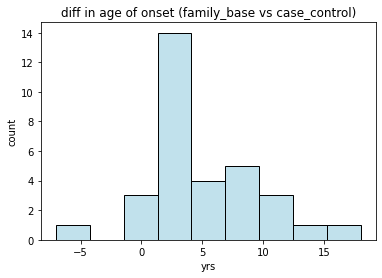

In [21]:
ax = sns.histplot(not_identitcal_duplicates.sort_values('source', ascending = False).groupby('SUBJID')['Age'].diff(), color = 'lightblue')
plt.title('diff in age of onset (family_base vs case_control)')
plt.xlabel('yrs')
plt.ylabel('count')
#

In [19]:
## except for age of onset, all the other columns are the same
not_identitcal_duplicates.groupby("SUBJID").Diagnosis.mean()

SUBJID
A-LOAD-LD000600    1.0
A-LOAD-LD000909    1.0
A-LOAD-LD001254    1.0
A-LOAD-LD001837    1.0
A-LOAD-LD002391    1.0
A-LOAD-LD002680    1.0
A-LOAD-LD002888    1.0
A-LOAD-LD003169    1.0
A-LOAD-LD003529    1.0
A-LOAD-LD003545    1.0
A-LOAD-LD003745    1.0
A-LOAD-LD004108    1.0
A-LOAD-LD004308    1.0
A-LOAD-LD004469    1.0
A-LOAD-LD004488    1.0
A-LOAD-LD004827    1.0
A-LOAD-LD005185    1.0
A-LOAD-LD005225    1.0
A-LOAD-LD005331    1.0
A-LOAD-LD007435    1.0
A-LOAD-LD007980    1.0
A-LOAD-LD010801    1.0
A-LOAD-LD010944    1.0
A-LOAD-LD011473    1.0
A-LOAD-LD011540    1.0
A-LOAD-LD011716    1.0
A-RAS-RA000001     1.0
A-RAS-RA000005     1.0
A-RAS-RA000009     1.0
A-RAS-RA000011     1.0
A-RAS-RA000012     1.0
A-RAS-RA000016     1.0
Name: Diagnosis, dtype: float64

In [22]:
not_identitcal_duplicates[not_identitcal_duplicates.SUBJID == 'A-LOAD-LD007980']

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
20654,A-LOAD-LD007980,0.0,65,58,34.0,5.0,1.0,case_control
8024,A-LOAD-LD007980,0.0,58,58,34.0,5.0,1.0,Family_based


In [20]:
not_identitcal_duplicates = not_identitcal_duplicates[(not_identitcal_duplicates['source'] == 'case_control') & (not_identitcal_duplicates.SUBJID != 'A-LOAD-LD007980')] ## 31 rows

In [130]:
duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control')]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
33405,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,case_control
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
31386,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,case_control
28806,A-NCRD-NC017018,1.0,73,NaN,34.0,5.0,1.0,case_control
28734,A-NCRD-NC007634,0.0,71,NaN,34.0,5.0,1.0,case_control
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [21]:
identical_duplicates = duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control') & (duplicates.SUBJID != 'A-LOAD-LD007980') ]
pheno_merge = pd.concat([pheno[(pheno.SUBJID != 'A-LOAD-LD007980') & (~pheno.SUBJID.isin(duplicated_ID))], not_identitcal_duplicates, identical_duplicates])

In [24]:
print(len(pheno_merge.SUBJID.unique()))
print(pheno_merge.isna().sum())

38163
SUBJID           0
Sex              0
Age              0
Age_baseline     0
APOE_reported    0
Race             0
Diagnosis        0
source           0
dtype: int64


In [29]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [31]:
pheno_merge[pheno_merge.Age_baseline.isnull()]
#pheno_merge.Age_baseline = pheno_merge.Age_baseline.fillna(pheno_merge.Age)
pheno_merge.loc[pheno_merge['Age_baseline'] == '90+', 'Age_baseline'] = 90
pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']] = pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']].astype(int)

In [32]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1,87,76,33,5,0,ADNI
1,ADNI_002_S_0685,1,90,89,33,5,0,ADNI
2,ADNI_002_S_0729,1,68,65,34,5,1,ADNI
3,ADNI_002_S_1155,0,69,57,33,5,0,ADNI
4,ADNI_002_S_1261,1,82,71,33,5,0,ADNI
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0,74,77,34,6,1,case_control
16135,A-CUHS-CU000387,1,87,71,23,6,0,case_control
16134,A-CUHS-CU000194,1,73,65,33,6,0,case_control
16133,A-CUHS-CU000169,1,87,84,33,5,0,case_control


In [177]:
pheno_merge.to_csv(path + 'phenotype_merged.tsv',sep = '\t', index = False)

In [33]:
pheno[pheno.SUBJID.isin(SUBJ_drop)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source


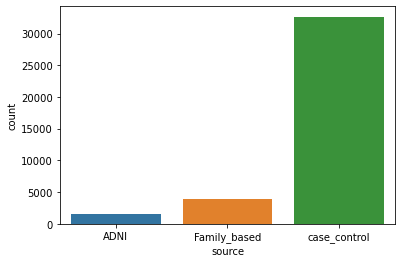

In [34]:
ax = sns.countplot(x="source", data=pheno_merge)

<AxesSubplot:title={'center':'data surce for pheno_merge'}>

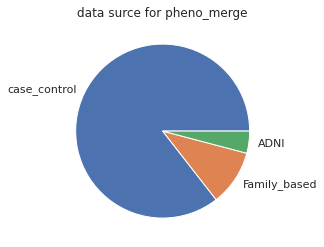

In [215]:
pheno_merge.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')


### check PSPCBD

In [30]:
PSPCBD_descript

,VARNAME,VARDESC,COMMENTS,VALUES,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,SUBJID,GCAD Subject ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sex,Sex,NaN,0=Male,1=Female,NaN,NaN,NaN,NaN,NaN
2,Diagnosis,Status of Diagnosis,NaN,0=PSP Control,1=PSP,2-CBD,NaN,NaN,NaN,NaN
3,AgeOnset,Age at Onset,Age values of 90 or more are censored and code...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AgeDeath,Age at Death,Age values of 90 or more are censored and code...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Race,NIH Racial Categories,NaN,1=American Indian/Alaska Native,2=Asian,3=Native Hawaiian or Other Pacific Islander,4=Black or African American,5=White,6=Other,NaN
6,APOE_WGS,APOE genotype derived from WGS pVCF,NaN,22,23,24,33,34,44,NA = No WGS genotype call available
7,Duplicate_SUBJID,Subject was identified to be genetically ident...,NaN,0 = No alternate SUBJID,1 = Alternate SUBJID exists,NC = Not Available/Not Checked,NaN,NaN,NaN,NaN
8,Comments,"Notes about diagnosis coversions, updates, cor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Latest_Update_Version,Release version of subject's most recent update,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')
PSPCBD['Diagnosis'].value_counts()

1    2340
2     335
0     128
Name: Diagnosis, dtype: int64

In [36]:
PSPCBD.loc[PSPCBD['Diagnosis'] == 2, 'Diagnosis'] = 1
print(PSPCBD.Diagnosis.value_counts())

1    2675
0     128
Name: Diagnosis, dtype: int64


In [37]:
PSPCBD[PSPCBD.SUBJID.isin(pheno.SUBJID)]

,SUBJID,Sex,Diagnosis,AgeOnset,AgeDeath,Race,APOE_WGS,Duplicate_SUBJID,Comments,Latest_Update_Version,Base_Diagnosis,Base_Version,Update_Baseline,Update_Latest,Update_Diagnosis,Correction,Consent


In [44]:
pheno[pheno.SUBJID.isin(PSPCBD.SUBJID)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source


In [38]:
## Merge PSPCBD with pheno
PSPCBD["source"] = "PSPCBD"
PSPCBD = PSPCBD.rename(columns={"AgeOnset":"Age", "APOE_WGS":"APOE_reported"})
PSPCBD = PSPCBD.loc[:,['SUBJID','Sex','Diagnosis', 'Age','APOE_reported','Race','source']]
pheno_merge_new = pheno_merge.append(PSPCBD)

In [41]:
pheno_merge_new.Age_baseline = pheno_merge_new.Age_baseline.fillna(pheno_merge_new.Age)
pheno_merge_new.loc[pheno_merge_new['Age'] == '90+', 'Age'] = 90
pheno_merge_new.loc[pheno_merge_new['Age_baseline'] == '90+', 'Age_baseline'] = 90

case_control    32643
Family_based     3955
PSPCBD           2803
ADNI             1565
Name: source, dtype: int64


<AxesSubplot:title={'center':'data surce for pheno_merge'}>

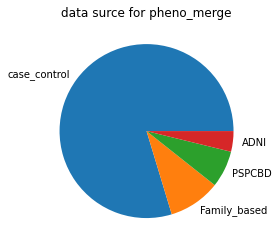

In [43]:
print(pheno_merge_new.source.value_counts())
pheno_merge_new.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')

In [44]:
## Use the pheno with PSPCBD added
pheno_merge_new.to_csv(path + 'phenotype_merged_PSPCBD.tsv',sep = '\t', index = False)
pheno_merge = pheno_merge_new

## add sample id

In [105]:
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info
#pheno_merge = pd.read_csv(path + 'phenotype_merged.tsv', sep = '\t') 
pheno_merge = pd.read_csv(path + 'phenotype_merged_PSPCBD.tsv', sep = '\t') 


In [80]:
manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)].Sequencing_Center.value_counts()

USUHS                16207
Broad                 5496
WashU                 4839
CU_IGM                3763
Baylor                3595
UM_HIHG               2819
Illumina              1447
NYGC                  1170
MGI                    930
MACROGEN               886
USUHS/Miami            720
Otogenetics            653
CHOP                   346
FGC                    330
PGFI                   117
IDOM                   103
UW_GenomeSciences       57
GENENTECH               51
MEDGENOME                4
Name: Sequencing_Center, dtype: int64

In [45]:
manifest.groupby(['Sequencing_Center','SAMPLE_USE'])['SUBJID'].count()

Sequencing_Center  SAMPLE_USE
Baylor             WES            2368
                   WGS            1272
Broad              WES            4583
                   WGS            1493
CHOP               WES             346
CU_IGM             WES            3861
FGC                WES             330
GENENTECH          WGS              55
IDOM               WES             103
Illumina           WGS            1450
MACROGEN           WGS             886
MEDGENOME          WGS            2686
MGI                WES            1036
NYGC               WGS            1646
Otogenetics        WES             714
PGFI               WES             117
UM_HIHG            WES            3265
USUHS              WGS           24506
USUHS/Miami        WGS            1040
UW_GenomeSciences  WES              75
WashU              WES            3703
                   WGS            1327
Name: SUBJID, dtype: int64

In [46]:
manifest.SampleID.value_counts().max()

1

In [47]:
manifest.SUBJID.value_counts()

A-CUHS-CU001163    13
A-CUHS-CU001166    13
A-CUHS-CU001167    12
A-CUHS-CU009833    10
A-NCRD-NC005389    10
                   ..
A-AMSH-AM000293     1
A-AMSH-AM000215     1
A-ADC-AD013962      1
G-LSID-LS000712     1
A-ADC-AD014447      1
Name: SUBJID, Length: 51992, dtype: int64

In [48]:
## the only two rows in manifest file that got removed because appearing in SUBJ_drop
print(manifest[(manifest.SUBJID.isin(pheno_merge.SUBJID)) & (manifest.SUBJID.isin(SUBJ_drop.SUBJID))])

manifest = manifest[(manifest.SUBJID.isin(pheno_merge.SUBJID)) & (~manifest.SUBJID.isin(SUBJ_drop.SUBJID))]

print(manifest.shape)
SUBJ_one2multi = manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)][manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)].SUBJID.duplicated(keep=False)]

               SUBJID                         SampleID BODY_SITE ANALYTE_TYPE  \
12879  A-MIA-UM000315  A-MIA-UM000315-UNK-MIA-19961724   Unknown          DNA   
12954  A-MIA-UM001976  A-MIA-UM001976-UNK-MIA-20010205   Unknown          DNA   

      Sequencing_Center       Sequencing_Platform SAMPLE_USE  \
12879           UM_HIHG  Illumina_HiSeq_2000/2500        WES   
12954           UM_HIHG  Illumina_HiSeq_2000/2500        WES   

       Technical_Replicate Study_DSS Sample_Set  
12879                    0  sa000006   snd10006  
12954                    0  sa000006   snd10006  
(43532, 10)


In [104]:
print(pheno_merge[pheno_merge.SUBJID == 'A-MIA-UM000315' ],
pheno_merge[pheno_merge.SUBJID == 'A-MIA-UM001976' ])

              SUBJID  Sex Age Age_baseline  APOE_reported  Race  Diagnosis  \
5261  A-MIA-UM000315    1  78           78           34.0   5.0          1   

            source  
5261  Family_based                 SUBJID  Sex Age Age_baseline  APOE_reported  Race  Diagnosis  \
5289  A-MIA-UM001976    1  78           78           33.0   5.0          1   

            source  
5289  Family_based  


#### Process the duplicated SUBJID

In [49]:
## extract the WGS one if theres one
manifest_multi_WGS = manifest[(manifest.SUBJID.duplicated(keep=False)) & (manifest.SAMPLE_USE == 'WGS')].sort_values("SUBJID")
manifest_multi_WGS

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
21390,A-ACT-AC000014,A-ACT-AC000014-BL-NCR-15AD78694,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
21391,A-ACT-AC000034,A-ACT-AC000034-BL-NCR-16AD84906,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23048,A-ACT-AC000057,A-ACT-AC000057-BL-NCR-15AD78356,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23049,A-ACT-AC000072,A-ACT-AC000072-BL-NCR-15AD77250,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23050,A-ACT-AC000088,A-ACT-AC000088-BL-NCR-15AD76548,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
...,...,...,...,...,...,...,...,...,...,...
31299,P-UPN-PSP10123,P-UPN-PSP10123-BL-UPN-119413,Blood,DNA,USUHS,Illumina_HiSeqX,WGS,0,sa000015,snd10015
25861,P-UPN-PSP10695,P-UPN-PSP8397-UNK-UPN-2214,Unknown,DNA,MACROGEN,Illumina_HiSeqX,WGS,0,sa000016,snd10016
31541,P-UPN-PSP10695,P-UPN-PSP10695-UNK-UPN-108077,Unknown,DNA,USUHS,Illumina_HiSeqX,WGS,0,sa000015,snd10015
31543,P-UPN-PSP10698,P-UPN-PSP10698-UNK-UPN-112570,Unknown,DNA,USUHS,Illumina_HiSeqX,WGS,0,sa000015,snd10015


In [50]:
manifest_multi_WGS.Technical_Replicate.value_counts()

0    4824
1      63
Name: Technical_Replicate, dtype: int64

In [51]:
manifest[manifest.Technical_Replicate == 1].value_counts('SUBJID')

SUBJID
A-CUHS-CU001167    12
A-CUHS-CU001166    12
A-CUHS-CU001163    12
A-NCRD-NC005389     9
A-LOAD-LD004371     9
A-CUHS-CU009833     9
C-CHS-51381         3
C-CHS-30738         3
A-ADC-AD003299      3
A-ADC-AD003250      3
A-ADC-AD000263      3
A-ACT-AC003410      3
A-ACT-AC003403      3
A-ACT-AC002972      3
A-ACT-AC002970      3
C-CHS-50100         2
dtype: int64

In [52]:
manifest[manifest.Technical_Replicate == 1].groupby(['SAMPLE_USE','SUBJID'])['SUBJID'].count()

SAMPLE_USE  SUBJID         
WES         A-ACT-AC002970      3
            A-ACT-AC002972      3
            A-ACT-AC003403      3
            A-ACT-AC003410      3
            A-ADC-AD000263      3
            A-ADC-AD003250      3
            A-ADC-AD003299      3
            C-CHS-30738         3
            C-CHS-50100         2
            C-CHS-51381         3
WGS         A-CUHS-CU001163    12
            A-CUHS-CU001166    12
            A-CUHS-CU001167    12
            A-CUHS-CU009833     9
            A-LOAD-LD004371     9
            A-NCRD-NC005389     9
Name: SUBJID, dtype: int64

In [130]:
manifest[manifest.SUBJID == 'A-CUHS-CU001167']

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
20581,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1,Blood,DNA,Baylor,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
20582,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1r,Blood,DNA,Broad,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
20583,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1w,Blood,DNA,WashU,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
21125,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1dea,Blood,DNA,Baylor,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21126,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1der,Blood,DNA,Broad,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21127,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1dew,Blood,DNA,WashU,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21128,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1fa,Blood,DNA,Baylor,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21129,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1fr,Blood,DNA,Broad,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21130,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1fw,Blood,DNA,WashU,Illumina_HiSeqX,WGS,1,sa000001,snd10001
56851,A-CUHS-CU001167,A-CUHS-CU001167-BL-COL-32167BL1u1-F01,Blood,DNA,USUHS,Illumina_HiSeqX,WGS,1,sa000001,snd10031


In [85]:
manifest_multi_WGS[manifest_multi_WGS.duplicated(subset = 'SUBJID', keep = False)].value_counts('SUBJID')

SUBJID
A-CUHS-CU001166    13
A-CUHS-CU001163    13
A-CUHS-CU001167    12
A-CUHS-CU009833    10
A-NCRD-NC005389    10
                   ..
A-ADC-AD016243      2
A-ADC-AD016242      2
A-ADC-AD016234      2
A-ADC-AD016232      2
A-ADC-AD000017      2
Length: 629, dtype: int64

In [53]:
manifest_multi_WGS = manifest_multi_WGS.drop_duplicates(subset= 'SUBJID')  ## only keep the first one

In [54]:
## WES
manifest_multi_WES = manifest[(manifest.SUBJID.duplicated(keep=False)) & (~manifest.SUBJID.isin(manifest_multi_WGS.SUBJID))]
manifest_multi_WES = manifest_multi_WES.drop_duplicates(subset= 'SUBJID')
print(manifest_multi_WES.shape)

(195, 10)


In [55]:
manifest_merge = pd.concat([manifest[(~manifest.SUBJID.isin(manifest_multi_WES.SUBJID)) & (~manifest.SUBJID.isin(manifest_multi_WGS.SUBJID))], manifest_multi_WES, manifest_multi_WGS])

In [56]:
manifest_merge.shape

(39049, 10)

In [140]:
len(manifest_merge.SUBJID.unique())

39049

In [87]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1,87,76,33.0,5.0,0,ADNI
1,ADNI_002_S_0685,1,90,89,33.0,5.0,0,ADNI
2,ADNI_002_S_0729,1,68,65,34.0,5.0,1,ADNI
3,ADNI_002_S_1155,0,69,57,33.0,5.0,0,ADNI
4,ADNI_002_S_1261,1,82,71,33.0,5.0,0,ADNI
...,...,...,...,...,...,...,...,...
2798,P-WZB-PSP10181,0,74,74,33.0,5.0,1,PSPCBD
2799,P-WZB-PSP10182,0,79,79,33.0,5.0,1,PSPCBD
2800,P-WZB-PSP5049,0,63,63,33.0,5.0,1,PSPCBD
2801,P-WZB-PSP5050,0,56,56,34.0,5.0,1,PSPCBD


In [ ]:
pheno_merge.shape

In [57]:
pheno_w_sampleID = pheno_merge.merge(manifest_merge)

In [58]:
pheno_w_sampleID.shape


(39049, 17)

In [59]:
pheno_w_sampleID.SAMPLE_USE.value_counts()

WGS    23552
WES    15497
Name: SAMPLE_USE, dtype: int64

In [145]:
pheno_w_sampleID.to_csv(path+'pheno_merge_PSPCBD_sampleID.tsv', sep = '\t', index = False)

In [177]:
pheno_merge[~pheno_merge.SUBJID.isin(manifest_merge.SUBJID)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
1575,A-CUHS-CU000386,0,74,74,33,6,0,Family_based
1576,A-CUHS-CU000388,0,81,81,23,6,0,Family_based
1577,A-CUHS-CU000389,0,76,76,33,6,0,Family_based
1578,A-CUHS-CU000390,0,64,57,33,6,0,Family_based
1580,A-CUHS-CU000401,1,59,59,33,6,0,Family_based
...,...,...,...,...,...,...,...,...
5502,A-LOAD-LD014144,1,61,61,44,5,1,Family_based
5503,A-LOAD-LD010144,1,74,80,34,5,1,Family_based
5517,A-CUHS-CU007232,0,73,77,34,5,1,Family_based
5518,A-CUHS-CU007253,1,65,69,44,4,1,Family_based


### check king

In [66]:
#king_manifest = pd.read_csv(path+'pheno_merge_sampleID_king.tsv', sep = '\t')
king = np.loadtxt("/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/unrelated_samples.txt", dtype=str) ## The non-related individual's sample ID calculate from Kinship only have sample I

In [67]:
king_manifest.shape

(36210, 17)

In [68]:
pheno_w_sampleID.shape

(39049, 17)

In [70]:
pheno_w_sampleID[pheno_w_sampleID.SampleID.isin(king)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
1,ADNI_002_S_0685,1,90,89,33.0,5.0,0,ADNI,ADNI_002_S_0685,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
3,ADNI_002_S_1155,0,69,57,33.0,5.0,0,ADNI,ADNI_002_S_1155,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
4,ADNI_002_S_1261,1,82,71,33.0,5.0,0,ADNI,ADNI_002_S_1261,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
7,ADNI_002_S_2010,1,68,62,34.0,6.0,0,ADNI,ADNI_002_S_2010,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
9,ADNI_002_S_2073,1,69,63,33.0,5.0,0,ADNI,ADNI_002_S_2073,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39044,P-WZB-PSP10181,0,74,74,33.0,5.0,1,PSPCBD,P-WZB-PSP10181-UNK-UPN-S0042010BB,Unknown,DNA,MACROGEN,Illumina_HiSeqX,WGS,0,sa000016,snd10016
39045,P-WZB-PSP10182,0,79,79,33.0,5.0,1,PSPCBD,P-WZB-PSP10182-UNK-UPN-S0352010B,Unknown,DNA,MACROGEN,Illumina_HiSeqX,WGS,0,sa000016,snd10016
39046,P-WZB-PSP5049,0,63,63,33.0,5.0,1,PSPCBD,P-WZB-PSP5049-UNK-UPN-S17704MuK350,Unknown,DNA,MACROGEN,Illumina_HiSeqX,WGS,0,sa000016,snd10016
39047,P-WZB-PSP5050,0,56,56,34.0,5.0,1,PSPCBD,P-WZB-PSP5050-UNK-UPN-S00201MuK180,Unknown,DNA,MACROGEN,Illumina_HiSeqX,WGS,0,sa000016,snd10016


## Merge pheno with VCF (dont care about kingship)

In [78]:
pheno_vcf = pheno_w_sampleID[pheno_w_sampleID.SampleID.isin(vcf.FID)]
pheno_vcf.to_csv(path+'pheno_vcf_merge.tsv', sep = '\t', index = False)

In [74]:
vcf[vcf.FID != vcf.IID]

,Unnamed: 0,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS


In [81]:
pheno_vcf.shape

(23552, 17)

<AxesSubplot:title={'center':'data surce for pheno_vcf_merge'}>

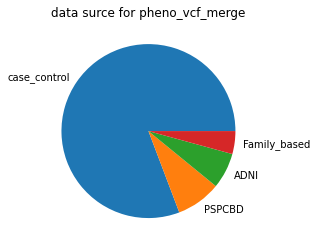

In [88]:
pheno_vcf.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_vcf_merge')

In [83]:
pheno_vcf.Diagnosis.value_counts()11

1    12122
0    11430
Name: Diagnosis, dtype: int64

In [85]:
pheno_vcf.SAMPLE_USE.value_counts()

WGS    23552
Name: SAMPLE_USE, dtype: int64